# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import os
import xarray
import rasterio
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from owslib.wms import WebMapService
from IPython.display import Image

# # Create custom cmap with dark grey at end 
#fires_cmap = get_cmap('YlOrRd').reversed()
fires_cmap = get_cmap('YlOrRd')  #.reversed()
fires_cmap.set_over('#29292b')  # Lighter gray
fires_cmap.set_over('#161617')

#dc = datacube.Datacube(app="DEA_hotspots")


/tmp/ipykernel_813/4215565096.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  fires_cmap = get_cmap('YlOrRd')  #.reversed()


## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [2]:
# Setup params
name = 'namadgi'  # name used for output files
timezone = 'Australia/Canberra'
from_date = '2020-01-27'
to_date = '2020-02-12'
end_ani_date = to_date
y_max, x_min = -35.370737, 148.668766  # top left coordinates of bbox
y_min, x_max = -36.021953, 149.315662  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
ahi=True
# ahi=False
avhrr=True
modis=True
viirs=True

# Setup params
name = 'fraser'  # name used for output files
timezone = 'Australia/Brisbane'
from_date = '2020-10-13'
to_date = '2020-12-15'
end_ani_date = to_date
y_max, x_min = -24.56, 152.67  # top left coordinates of bbox
y_min, x_max = -25.90, 153.68  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
ahi=True
ahi=False
avhrr=True
modis=True
viirs=True


# Setup params
name = 'perth'  # name used for output files
timezone = 'Australia/Perth'
from_date = '2021-02-01'
to_date = '2021-02-06'
end_ani_date = to_date
y_max, x_min = -31.608891, 115.8  # top left coordinates of bbox
y_min, x_max = -31.92123, 116.5  # bottom right coordinates of bbox
min_confidence = 0  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
ahi=True
ahi=False
avhrr=True
modis=True
viirs=True


# Setup params
name = 'nt'  # name used for output files
timezone = 'Australia/Darwin'
from_date = '2023-08-01'
to_date = '2023-12-31'
end_ani_date = to_date
y_max, x_min = -20.14400, 130.53370 
y_min, x_max = -23.90842, 135.16321
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
ahi=True
# ahi=False
avhrr=True
modis=True
viirs=True

# # Setup params
# name = 'vicfires'  # name used for output files
# time_period = 28  # days from current date to include in animation (e.g. a month or week of data)
# y_max, x_min = -34.505141, 146.652687  # top left coordinates of bbox
# y_min, x_max = -38.062278, 151.305470  # bottom right coordinates of bbox
# min_confidence = 20  # minimum confidence value of hotspots to include in animation
# max_features = 500000  # maximum features to load from WFS

# Visualisation params
frame_freq = '1H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 10  # size to plot hotspots on map
hotspots_alpha = 1.0 # transperancy to plot hotspots on map
fade_hours = 24  # hours used to fade hotspots from yellow to black
geomedian_res = 0.02  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

<Axes: >

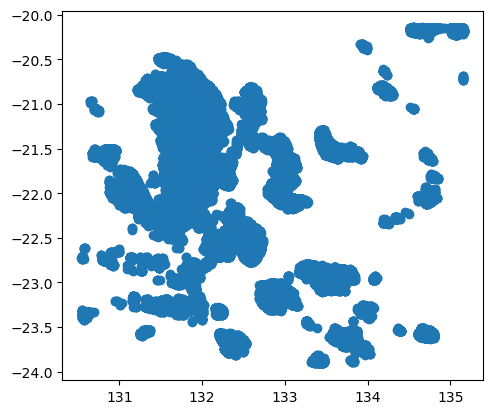

In [3]:
# Load WFS query data
ahi_string = '(sensor=%27AHI%27%20AND%20(product=%27LANDGATE%20AHI%27))%20OR%20' if ahi else ''
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
modis_string = '(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20' if modis else ''
viirs_string = '(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27))' if viirs else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({ahi_string}{avhrr_string}{modis_string}{viirs_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)

# Filter by confidence
hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# Fix datetime
hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# Extract required columns
hotspots_gdf = hotspots_gdf.loc[:, [
    'datetime', 'latitude', 'longitude', 'confidence', 'geometry'
]]
hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
hotspots_gdf.plot()

## Load 2018 geomedian underlay

In [4]:
import uuid
from owslib.wms import WebMapService
import subprocess

def wms_xarray(url, 
               layer, 
               bbox, 
               layerstyle, 
               layertime,                
               layerformat='png', 
               layersizex=512, 
               layersizey=512,
               epsg='EPSG:4326'):
    """
    Loads WMS data as an xarray.Dataset object.
    """

    # Get extent
    y_max, x_min, y_min, x_max = bbox

    # Create tempory path files
    unique_id = str(uuid.uuid4())
    infile = f'{unique_id}.tif'
    outfile = f'{unique_id}_georef.tif'

    wms = WebMapService(url, version='1.3.0')
    crs = sorted(wms[layer].crsOptions)
    time = wms[layer].timepositions
    
    output = wms.getmap(layers=[layer],
                styles=[layerstyle],
                srs='EPSG:4326',
                bbox=(x_min, y_min, x_max, y_max),
                size=(layersizex, layersizey),
                format='image/'+layerformat,
                time=layertime
                )
            
    with open(infile, 'wb') as out:
        out.write(output.read())   
   
    # TODO write as python rather than system call
    subprocess.call(['gdal_translate','-a_srs', epsg, 
                     '-a_ullr', str(x_min), str(y_max), str(x_max), str(y_min), 
                     infile, outfile])
    ds = xarray.open_rasterio(outfile)
    
    # Remove temporary rasters
    os.remove(outfile)
    os.remove(infile)
    
    return(ds)

Input file size is 512, 512
0...10...20...30...40...50...60...70...80...90...100 - done.


/tmp/ipykernel_813/1997939561.py:46: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(outfile)


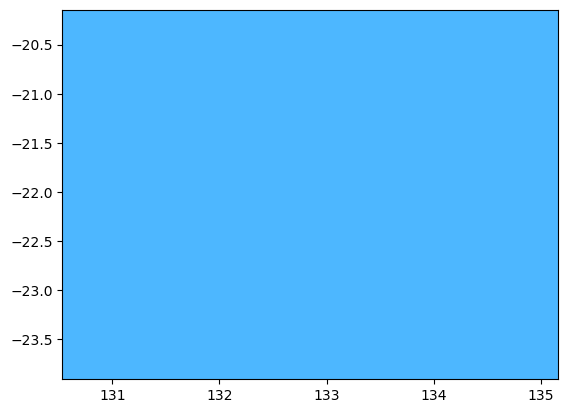

In [9]:
wms_extent = (y_max, x_min, y_min, x_max)

ds = wms_xarray(url="https://ows.dea.ga.gov.au/",  #WMS for background image
                layer="ga_ls8c_nbart_gm_cyear_3",  #WMS layer name
                bbox=wms_extent, 
                layerstyle='simple_rgb',
                layertime='2019-01-01T00:00:00.000Z')
ds.isel(band=[0, 1, 2]).plot.imshow(alpha=0.7, 
                                    add_labels=False, robust=True) 

### Load spatial data

In [6]:
# boundary = gpd.read_file('https://data.gov.au/geoserver/nsw-state-boundary/wfs?request=GetFeature&typeName=ckan_a1b278b1_59ef_4dea_8468_50eb09967f18&outputFormat=json')
# # boundary = gpd.read_file('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson').simplify(tolerance=0.02)

# from shapely.geometry import box
# boundary = gpd.clip(boundary, box(x_min, y_min, x_max, y_max).buffer(0.01))
# boundary.plot()

In [37]:
hotspots_gdf['datetime'].lt(comp_date)

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [40]:
hotspots_gdf['datetime'].dt.tz_localize(None) < comp_date

97226    False
97227    False
97225    False
97239    False
97238    False
         ...  
32224    False
32225    False
32226    False
32220    False
32181    False
Name: datetime, Length: 107362, dtype: bool

## Generate animation frames

ValueError: aspect must be finite and positive 

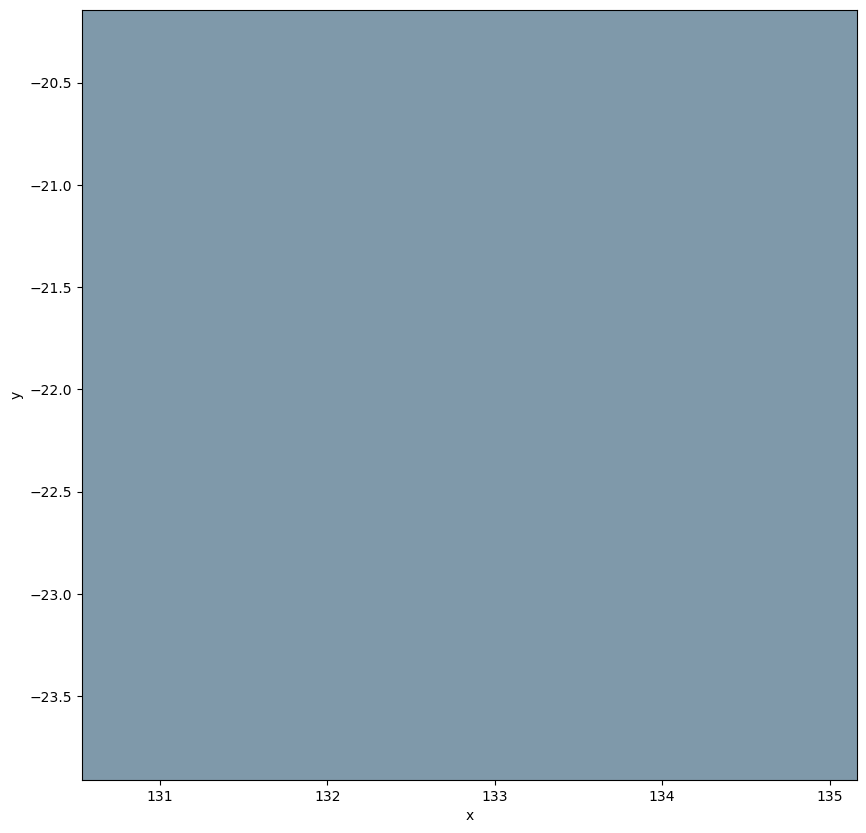

In [45]:
# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(str(hotspots_gdf.datetime.min())[0:10], 
                           end_ani_date, 
                           freq=frame_freq)[2:]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(f"{comp_date}", end='\r')

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'].dt.tz_localize(None) < comp_date.tz_localize(None)].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date.tz_localize(None) - hotspots_prev['datetime'].dt.tz_localize(None))).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)

    # Plot Geomedian as underlay/
    ds[[0,1,2]].plot.imshow(ax=ax, vmax=300)
    
    #Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours)
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
#             f"{comp_date.tz_localize(tz='UTC').tz_convert(timezone):%Y-%m-%d %H:%M}",
            f"{comp_date.tz_localize(tz='UTC').tz_convert(timezone):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
        
#     boundary.plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    
#     labels = {
# #         'Sydney': (151.2093, -33.8688),               
#         'Canberra\n\nAustralian\nCapital\nTerritory': (148.77, -35.475),               
# #         'Melbourne': (144.9631, -37.8136)
#     }

#     for label, (x, y) in labels.items():
#         plt.annotate(s=label,
#                          xy=(x + 0.25, y), 
#                          c='white',
#                          fontname='Liberation Sans',
#                          fontsize=13), 
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
                bbox_inches='tight',
                dpi=200,
                pad_inches=0,
               )
    plt.cla()

In [8]:
# Combine using FFMPEG
!ffmpeg -y -r 10 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-31:in_h-31 -pix_fmt yuv420p animation_{name}.mp4

ffmpeg version 3.3.4-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-4) 20170820
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libfribidi --enable-libass --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6.

## Combine animations side by side

In [8]:
# !ffmpeg -y -i animation_adelaideriver.mp4 -i animation_adelaideriver_h8.mp4 -filter_complex "hstack,format=yuv420p" -c:v libx264 -crf 18 output.mp4

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [14]:
# print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)